# Фундаментальные концепции ИИ

## Лабораторная работа №4
### Восстановление функции распренделения вероятности

Выполнил студент группы М8О-109СВ-24 Кучев Антон

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate

In [2]:
np.random.seed(0)
data = np.concatenate([
    np.random.normal(loc=2, scale=1, size=(100, 1)),
    np.random.normal(loc=-5, scale=1, size=(100, 1))
])

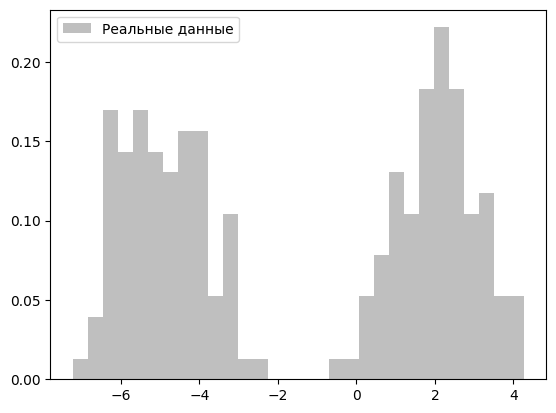

In [3]:
plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Реальные данные')

plt.legend()
plt.show()

### Ядерная оценка плотности

In [4]:
def gauss_kernel(x):
    return (2*np.pi)**(-0.5) * np.exp((-x**2)/2)

def exp_kernel(x):
    return 0.5 * np.exp(-np.abs(x))

def epanechnikov_kernel(x):
    return 0.75 * (1 - x**2)*(np.abs(x) <= 1)

In [5]:
def kernel_density_estimation(data, x_grid, kernel, h):
    n_points = len(x_grid)
    densities = np.zeros(n_points)

    for i, x in enumerate(x_grid):
        densities[i] = np.sum([kernel((x - xi)/h) for xi in data]) / (len(data) * h)

    return densities

In [6]:
x_points = np.linspace(-8, 5, 1000)
h = [0.1, 0.5, 1.0]

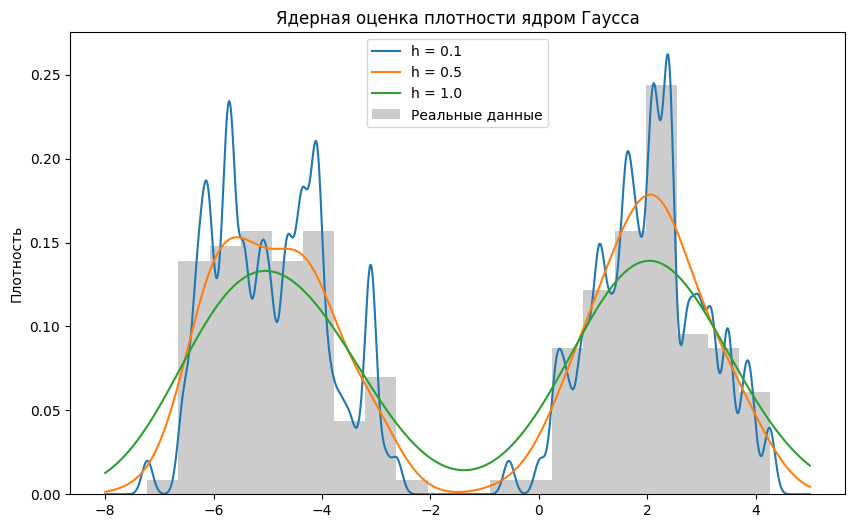

In [7]:
plt.figure(figsize=(10, 6))

for bw in h:
    density = kernel_density_estimation(data, x_points, gauss_kernel, bw)
    plt.plot(x_points, density, label=f"h = {bw}")

plt.hist(data, bins=20, density=True, alpha=0.4, color='gray', label='Реальные данные')
plt.title("Ядерная оценка плотности ядром Гаусса")
plt.ylabel("Плотность")
plt.legend()
plt.show()

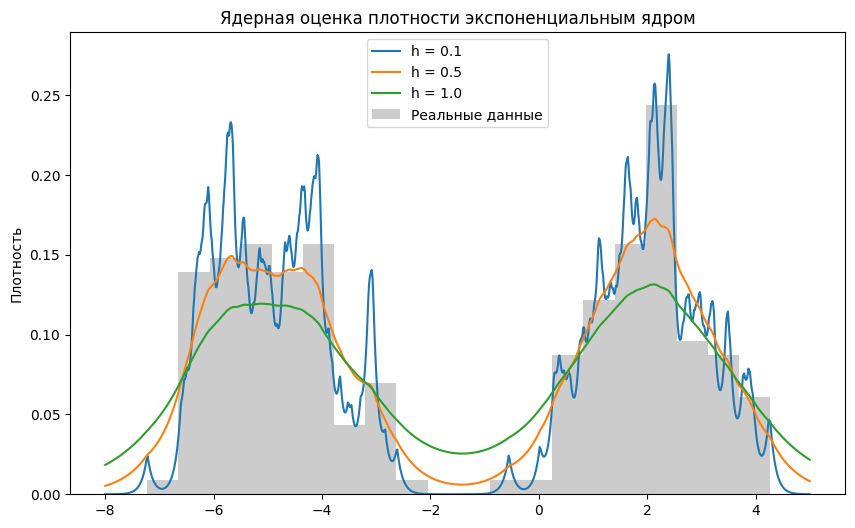

In [8]:
plt.figure(figsize=(10, 6))

for bw in h:
    density = kernel_density_estimation(data, x_points, exp_kernel, bw)
    plt.plot(x_points, density, label=f"h = {bw}")

plt.hist(data, bins=20, density=True, alpha=0.4, color='gray', label='Реальные данные')
plt.title("Ядерная оценка плотности экспоненциальным ядром")
plt.ylabel("Плотность")
plt.legend()
plt.show()

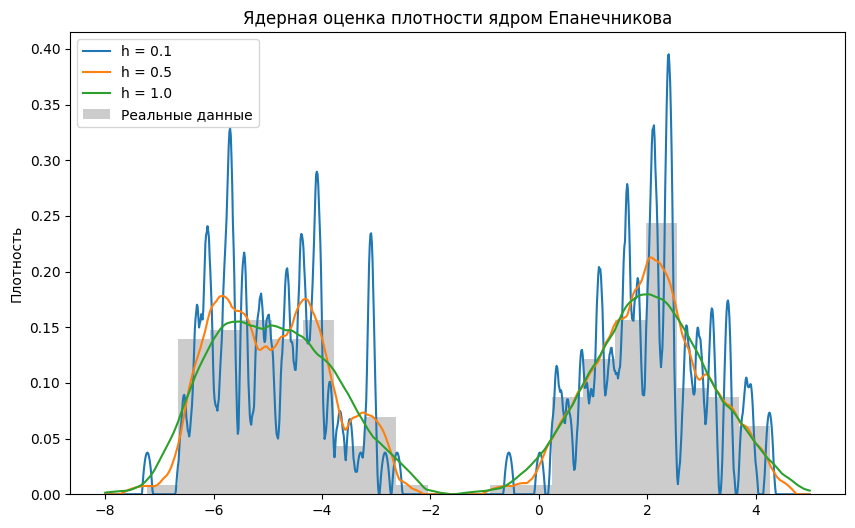

In [9]:
plt.figure(figsize=(10, 6))

for bw in h:
    density = kernel_density_estimation(data, x_points, epanechnikov_kernel, bw)
    plt.plot(x_points, density, label=f"h = {bw}")

plt.hist(data, bins=20, density=True, alpha=0.4, color='gray', label='Реальные данные')
plt.title("Ядерная оценка плотности ядром Епанечникова")
plt.ylabel("Плотность")
plt.legend()
plt.show()

### EM-алгоритм

Результаты EM-алгоритма:
{'mu1': np.float64(-5.1967692521659785), 'sigma1': np.float64(0.9294227776146046), 'pi1': np.float64(0.5000026917760814), 'mu2': np.float64(1.940778710422175), 'sigma2': np.float64(0.9519984793614502), 'pi2': np.float64(0.49999730822391864)}


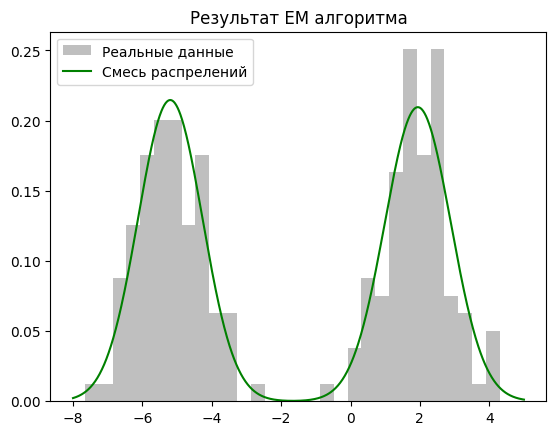

In [10]:
data = np.concatenate([
    np.random.normal(loc=2, scale=1, size=(100, 1)),
    np.random.normal(loc=-5, scale=1, size=(100, 1))
]).flatten()

def gaussian_pdf(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std)**2)

def em_algorithm(data, num_iterations=100, tol=1e-6):
    n = len(data)
    np.random.seed(0)

    mu1, mu2 = np.random.choice(data, 2)
    sigma1, sigma2 = 1.0, 1.0
    pi1, pi2 = 0.5, 0.5

    for _ in range(num_iterations):
        # E-шаг
        g1 = pi1 * gaussian_pdf(data, mu1, sigma1)
        g2 = pi2 * gaussian_pdf(data, mu2, sigma2)
        
        g_sum = g1 + g2
        g1 /= g_sum
        g2 /= g_sum

        # M-шаг
        N1 = np.sum(g1)
        N2 = np.sum(g2)

        mu1_new = np.sum(g1 * data) / N1
        mu2_new = np.sum(g2 * data) / N2

        sigma1_new = np.sqrt(np.sum(g1 * (data - mu1_new)**2) / N1)
        sigma2_new = np.sqrt(np.sum(g2 * (data - mu2_new)**2) / N2)

        pi1_new = N1 / n
        pi2_new = N2 / n

        if (np.abs(mu1 - mu1_new) < tol and
            np.abs(mu2 - mu2_new) < tol and
            np.abs(sigma1 - sigma1_new) < tol and
            np.abs(sigma2 - sigma2_new) < tol):
            break

        mu1, mu2 = mu1_new, mu2_new
        sigma1, sigma2 = sigma1_new, sigma2_new
        pi1, pi2 = pi1_new, pi2_new

    return {
        'mu1': mu1, 'sigma1': sigma1, 'pi1': pi1,
        'mu2': mu2, 'sigma2': sigma2, 'pi2': pi2
    }

params = em_algorithm(data)
print("Результаты EM-алгоритма:")
print(params)

# Визуализация
x = np.linspace(-8, 5, 1000)
pdf1 = params['pi1'] * gaussian_pdf(x, params['mu1'], params['sigma1'])
pdf2 = params['pi2'] * gaussian_pdf(x, params['mu2'], params['sigma2'])

plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Реальные данные')
plt.plot(x, pdf1 + pdf2, label='Смесь распрелений', color='green')
plt.legend()
plt.title('Результат EM алгоритма')
plt.show()


### Метод Метрополиса-Гастингса

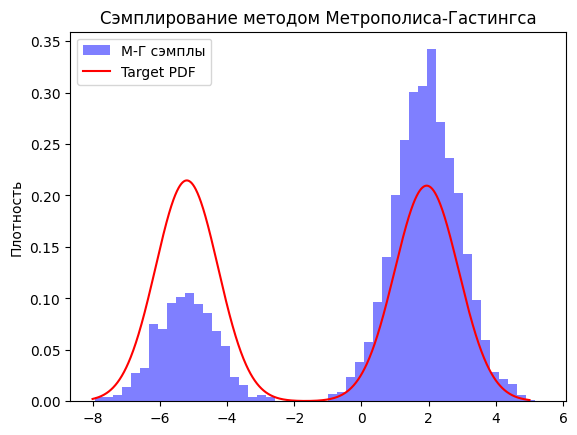

In [11]:
def metropolis_hastings(target_pdf, proposal_sampler, initial_state, num_samples):
    samples = []
    current_state = initial_state
    
    for _ in range(num_samples):
        proposed_state = proposal_sampler(current_state)
        acceptance_ratio = target_pdf(proposed_state) / target_pdf(current_state)

        if np.random.rand() < acceptance_ratio:
            current_state = proposed_state

        samples.append(current_state)

    return np.array(samples)

def target_pdf(x):
    return (params['pi1'] * gaussian_pdf(x, params['mu1'], params['sigma1']) +
            params['pi2'] * gaussian_pdf(x, params['mu2'], params['sigma2']))

def proposal_sampler(current_state):
    return np.random.normal(loc=current_state, scale=1.0)

initial_state = 0.0
num_samples = 10000
samples = metropolis_hastings(target_pdf, proposal_sampler, initial_state, num_samples)

plt.hist(samples, bins=50, density=True, alpha=0.5, color='blue', label='M-Г сэмплы')
plt.plot(x, target_pdf(x), label='Target PDF', color='red')
plt.title('Сэмплирование методом Метрополиса-Гастингса')
plt.ylabel('Плотность')
plt.legend()
plt.show()


### KL-дивергенция. Расстояние между реальным датасетом и восстановеленным методом Метрополиса-Гастингса

In [12]:
def KL_deivergence(p, q):
    p = p + 1e-10
    q = q + 1e-10
    return np.sum(p * np.log(p / q))

In [13]:
def get_and_plot_kl_div(hist1, hist2, bin_edges):
    kl_divergence = KL_deivergence(hist1, hist2)
    print(f"Расстояние Кульбака-Лейблера: {kl_divergence:.4f}")
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist1, width=bin_edges[1] - bin_edges[0], alpha=0.5, label="Реальные данные")
    plt.bar(bin_centers, hist2, width=bin_edges[1] - bin_edges[0], alpha=0.5, label="Восстановленные данные")
    plt.title("Сравнение распределений")
    plt.ylabel("Плотность")
    plt.legend()
    plt.show()

Расстояние Кульбака-Лейблера: 1.0548


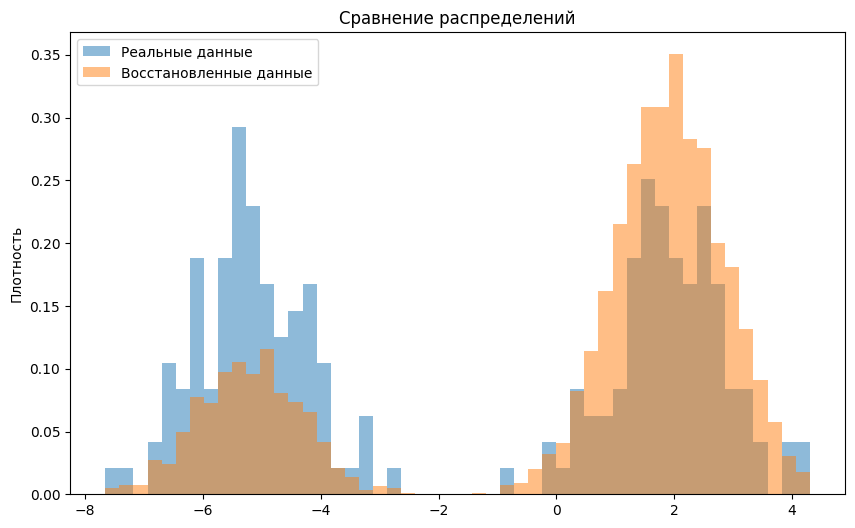

In [14]:
bins=50
hist1, bin_edges = np.histogram(data, bins=bins, density=True)
hist2, _ = np.histogram(samples, bins=bin_edges, density=True)

get_and_plot_kl_div(hist1, hist2, bin_edges)